# Machine Learning Approaches for News Analysis

By: Michael Mizzi

The scope of this workbook is to apply KNN on the features extracted from the two data sets provided, police press releases and news articles.

Dataset used : `data.csv`


## K-Nearest Neighbours [KNN] in our context:
- Is Regression or Classification adequate?
- What is the the optimal K paramter?
- Do we consider process time required? Do we need to optimize searching?
- Is KNN a suitable ML model to adopt in our scenario?

## 1. Introducton to Technique

Based on theoretical descriptions by Prof. Konstantinos Makantasis
delivered during ***Applied Machine Learning*** module (2025-2026)

### 1.1 Theory


The k-nearest neighbours (k-NN) method is a non-parametricalgorithm that classifies data points based on the majority class among their k closest neighbours in feature space.”

### 1.2 Suitability

## 2. Preprocessing

### 2.1 Importing Libraries and loading dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")
print(f"Shape of the dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded successfully.
Shape of the dataset: 219 rows, 54 columns


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          219 non-null    object 
 1   date_published              219 non-null    object 
 2   accident_datetime           219 non-null    object 
 3   accident_severity           219 non-null    object 
 4   total_injured               219 non-null    int64  
 5   city                        219 non-null    object 
 6   street                      219 non-null    object 
 7   accident_time_category      219 non-null    object 
 8   driver_under_18             219 non-null    bool   
 9   driver_18_to_24             219 non-null    bool   
 10  driver_25_to_49             219 non-null    bool   
 11  driver_50_to_64             219 non-null    bool   
 12  driver_65_plus              219 non-null    bool   
 13  driver_age_unknown          219 non

In [ ]:
# Keep only the specified columns
columns_to_keep = [
    #'id', 'date_published',
    'accident_datetime','accident_severity', 'total_injured',
    #'city', 'street',
    'accident_time_category',
    #'driver_under_18', 'driver_18_to_24', 'driver_25_to_49','driver_50_to_64', 'driver_65_plus', 'driver_age_unknown',
    'num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49',
    'num_drivers_50_to_64', 'num_drivers_65_plus', 'num_drivers_age_unknown',
    #'driver_male', 'driver_female', 'driver_gender_unknown',
    'num_drivers_male', 'num_drivers_female', 'num_drivers_gender_unknown', 'num_drivers_total',
    #'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike',
    #'vehicle_car', 'vehicle_van', 'vehicle_bus',
    'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle',
    'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus',
    'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', #'is_school_day_mt',
    'street_type', 'region', 'temperature_max', #'temperature_min', 'temperature_mean',
    #'precipitation_sum', 'windspeed_max',
    'is_raining', 'traffic_level'
   ]

df = df[columns_to_keep]

print(f"✓ Dataset filtered to {len(columns_to_keep)} columns")
print(f"New shape: {df.shape[0]} rows, {df.shape[1]} columns")

✓ Dataset filtered to 29 columns
New shape: 219 rows, 29 columns


In [ ]:
df.head()

,accident_datetime,accident_severity,total_injured,accident_time_category,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,...,num_vehicle_van,num_vehicle_bus,is_weekend,is_public_holiday_mt,is_school_holiday_mt,street_type,region,temperature_max,is_raining,traffic_level
0,2006-12-17 00:00:00,grievious,1,night,0,0,0,0,0,2,...,0,0,True,False,False,secondary,Central,18.0,True,LOW
1,2017-08-20 15:25:00,fatal,3,afternoon,0,0,2,0,0,0,...,0,0,True,False,True,secondary,Northern,30.0,False,MODERATE
2,2018-03-13 00:00:00,fatal,1,night,0,0,0,0,1,1,...,0,0,False,False,False,residential,Southern Harbour,16.8,False,LOW
3,2020-05-02 08:00:00,serious,1,early_morning,0,0,1,0,0,0,...,0,0,True,False,False,secondary,Central,20.3,False,LOW
4,2022-02-01 00:00:00,fatal,1,night,0,0,1,0,0,1,...,1,0,False,False,False,trunk,Southern Harbour,14.3,True,LOW


Filter data based on findings from 2_exploratory phase:


1.   Remove all accidents taking place before Nov '24
2.   Fill-in all feature data that is set as 'unknown'


In [ ]:
df['accident_datetime'] = pd.to_datetime(df['accident_datetime'])
df = df[df['accident_datetime'] >= '2024-11-01']

print(f"✓ Data filtered to include accidents from November 2024 onwards.")
print(f"New shape: {df.shape[0]} rows, {df.shape[1]} columns")

✓ Data filtered to include accidents from November 2024 onwards.
New shape: 209 rows, 29 columns


In [ ]:
columns_with_unknown = []
for col in df.columns:
    if df[col].astype(str).str.contains('unknown', case=False, na=False).any():
        columns_with_unknown.append(col)

if columns_with_unknown:
    print("Columns containing 'unknown' values:")
    for col_name in columns_with_unknown:
        print(f"- {col_name}")
else:
    print("No columns found containing 'unknown' values.")

No columns found containing 'unknown' values.


### 2.2 Scaling and Encoding data
Step 1: convert all data to numeric

Step 2: Normalize data --> this part will be computed after splitting dataset (train,val,test)

In [ ]:
# Extract features from 'accident_datetime'
df['accident_month'] = df['accident_datetime'].dt.month # return month number

# Perform one-hot encoding using pandas get_dummies
# This will create new columns for each category and drop the original columns
df = pd.get_dummies(df, columns=['accident_month'], prefix='accident_month')

# Drop the original 'accident_datetime' column as its derived features have been encoded
df = df.drop(columns=['accident_datetime'])

print("✓ One-hot encoding applied to derived features from 'accident_datetime'")
print(f"New shape of DataFrame after encoding: {df.shape[0]} rows, {df.shape[1]} columns")

✓ One-hot encoding applied to derived features from 'accident_datetime'
New shape of DataFrame after encoding: 209 rows, 39 columns


In [ ]:
# Define the ordinal mapping for accident_severity
# Assuming a logical order from least severe to most severe
severity_order = {
    'not injured': 0,
    'slight': 1,
    'grievious': 2,
    'serious': 3,
    'fatal': 4
}

# Apply the ordinal mapping to the 'accident_severity' column
df['accident_severity'] = df['accident_severity'].map(severity_order)

print("✓ 'accident_severity' column ordinally encoded and original column replaced.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded column:")
print(df['accident_severity'].head())

✓ 'accident_severity' column ordinally encoded and original column replaced.
New shape of DataFrame: 209 rows, 39 columns
First 5 rows of the new encoded column:
10    0
11    2
12    4
13    3
14    3
Name: accident_severity, dtype: int64


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the 'accident_time_category' column
accident_time_category_encoded = encoder.fit_transform(df[['accident_time_category']])

# Create a DataFrame from the encoded data
accident_time_category_df = pd.DataFrame(accident_time_category_encoded, columns=encoder.get_feature_names_out(['accident_time_category']))

# Reset index of df before concatenating to ensure proper alignment
df_reset = df.reset_index(drop=True)

# Concatenate the new DataFrame with the original df
df_combined = pd.concat([df_reset, accident_time_category_df], axis=1)

# Drop the original 'accident_time_category' column
df = df_combined.drop(columns=['accident_time_category'])

print("✓ 'accident_time_category' column one-hot encoded using scikit-learn.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded columns:")
print(df[accident_time_category_df.columns].head())

✓ 'accident_time_category' column one-hot encoded using scikit-learn.
New shape of DataFrame: 209 rows, 44 columns
First 5 rows of the new encoded columns:
   accident_time_category_afternoon  accident_time_category_early_morning  \
0                               1.0                                   0.0   
1                               0.0                                   0.0   
2                               1.0                                   0.0   
3                               1.0                                   0.0   
4                               0.0                                   0.0   

   accident_time_category_evening  accident_time_category_late_evening  \
0                             0.0                                  0.0   
1                             0.0                                  0.0   
2                             0.0                                  0.0   
3                             0.0                                  0.0   
4          

In [ ]:
# Define columns to be one-hot encoded
columns_to_onehot_encode = ['street_type', 'region']

# Perform one-hot encoding using pandas get_dummies
df = pd.get_dummies(df, columns=columns_to_onehot_encode, prefix=columns_to_onehot_encode)

print("✓ One-hot encoding applied to 'street_type' and 'region' columns.")
print(f"New shape of DataFrame after encoding: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded 'street_type' columns:")
print(df[[col for col in df.columns if 'street_type_' in col]].head())
print("First 5 rows of the new encoded 'region' columns:")
print(df[[col for col in df.columns if 'region_' in col]].head())

✓ One-hot encoding applied to 'street_type' and 'region' columns.
New shape of DataFrame after encoding: 209 rows, 53 columns
First 5 rows of the new encoded 'street_type' columns:
   street_type_other  street_type_primary  street_type_residential  \
0              False                False                    False   
1              False                False                     True   
2              False                False                    False   
3              False                False                    False   
4              False                 True                    False   

   street_type_secondary  street_type_tertiary  street_type_trunk  
0                  False                 False               True  
1                  False                 False              False  
2                  False                 False               True  
3                  False                 False               True  
4                  False                 False            

In [ ]:
# Define the ordinal mapping for traffic_level
traffic_level_order = {
    'LOW': 0,
    'MODERATE': 1,
    'HEAVY': 2
}

# Apply the ordinal mapping to the 'traffic_level' column
df['traffic_level_encoded'] = df['traffic_level'].map(traffic_level_order)

# Drop the original 'traffic_level' column
df = df.drop(columns=['traffic_level'])

print("✓ 'traffic_level' column ordinally encoded and original column replaced.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new 'traffic_level_encoded' column:")
print(df['traffic_level_encoded'].head())

✓ 'traffic_level' column ordinally encoded and original column replaced.
New shape of DataFrame: 209 rows, 53 columns
First 5 rows of the new 'traffic_level_encoded' column:
0    1
1    0
2    0
3    0
4    0
Name: traffic_level_encoded, dtype: int64


In [ ]:
# Identify boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns

# Convert boolean columns to int (0 or 1)
df[bool_cols] = df[bool_cols].astype(int)

print(f"✓ Converted {len(bool_cols)} boolean columns to integers (0 or 1).")
print("First 5 rows of the updated DataFrame (boolean columns are now 0/1):")

df.head()

✓ Converted 26 boolean columns to integers (0 or 1).
First 5 rows of the updated DataFrame (boolean columns are now 0/1):


,accident_severity,total_injured,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,...,street_type_residential,street_type_secondary,street_type_tertiary,street_type_trunk,region_Central,region_Gozo,region_Northern,region_South Eastern,region_Southern Harbour,traffic_level_encoded
0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,1,0,0,1,0,0,1
1,2,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,4,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,3,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,3,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   accident_severity                     209 non-null    int64  
 1   total_injured                         209 non-null    int64  
 2   num_drivers_under_18                  209 non-null    int64  
 3   num_drivers_18_to_24                  209 non-null    int64  
 4   num_drivers_25_to_49                  209 non-null    int64  
 5   num_drivers_50_to_64                  209 non-null    int64  
 6   num_drivers_65_plus                   209 non-null    int64  
 7   num_drivers_age_unknown               209 non-null    int64  
 8   num_drivers_male                      209 non-null    int64  
 9   num_drivers_female                    209 non-null    int64  
 10  num_drivers_gender_unknown            209 non-null    int64  
 11  num_drivers_total  

In [ ]:
df.head()

,accident_severity,total_injured,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,...,street_type_residential,street_type_secondary,street_type_tertiary,street_type_trunk,region_Central,region_Gozo,region_Northern,region_South Eastern,region_Southern Harbour,traffic_level_encoded
0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,1,0,0,1,0,0,1
1,2,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,4,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,3,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,3,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


## 3. Hyperparameter Tuning

Research hyper parameters for KNN (use of Gen AI)

## 4. Model Training

Step 1 --> split X (features), y (Labels)

In [ ]:
# Define the label columns
label_columns = ['accident_severity', 'total_injured']

# Create the labels DataFrame (y)
y = df[label_columns]

# Create the features DataFrame (X) by dropping the label columns from the original DataFrame
X = df.drop(columns=label_columns)

print("✓ DataFrame successfully split into features (X) and labels (y).")
print(f"Shape of X (features): {X.shape[0]} rows, {X.shape[1]} columns")
print(f"Shape of y (labels): {y.shape[0]} rows, {y.shape[1]} columns")
print("First 5 rows of X:")
print(X.head())
print("First 5 rows of y:")
print(y.head())

✓ DataFrame successfully split into features (X) and labels (y).
Shape of X (features): 209 rows, 51 columns
Shape of y (labels): 209 rows, 2 columns
First 5 rows of X:
   num_drivers_under_18  num_drivers_18_to_24  num_drivers_25_to_49  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   num_drivers_50_to_64  num_drivers_65_plus  num_drivers_age_unknown  \
0                     0                    1                        1   
1                     0                    0                        0   
2                     1                    0                        0   
3                     1                    0                        0   
4                     1                

split data set (70% train, 20% train, 10% validation)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% temporary (for test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the 30% temporary data into 20% test and 10% validation
# (20% of original is 2/3 of 30%, 10% of original is 1/3 of 30%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333333, random_state=42)

print("✓ Data successfully split into training, testing, and validation sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

✓ Data successfully split into training, testing, and validation sets.
Shape of X_train: (146, 51)
Shape of y_train: (146, 2)
Shape of X_test: (42, 51)
Shape of y_test: (42, 2)
Shape of X_val: (21, 51)
Shape of y_val: (21, 2)


normalize data --->

In [ ]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the training data (fit and transform)
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

# Apply StandardScaler to the test and validation data (transform only)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)
X_val = scaler.fit_transform(X_val)
y_val = scaler.fit_transform(y_val)

print(f"✓ Data normalized using StandardScaler.")
print("First 5 rows of X_train (normalized):")
print(X_train[:5])
print("First 5 rows of y_train (normalized):")
print(y_train[:5])

✓ Data normalized using StandardScaler.
First 5 rows of X_train (normalized):
[[-0.20701967  1.76453838  0.31443763 -0.58070559 -0.46518029 -0.37786244
  -1.48528149  3.11264869 -0.45454545  0.52039441 -0.11785113 -0.26094499
  -0.16783627  0.8439831   0.19885751 -0.32259749 -0.2563073  -0.65678958
  -0.20701967  1.04197614  1.32919018 -0.66749124 -0.28544961 -0.36301921
  -0.2244097  -0.27116307 -0.27116307 -0.32566947  2.75467517 -0.43242557
  -0.33838413 -0.2244097  -0.33838413  1.45133834 -0.38678974 -0.375
  -0.2563073  -0.4871223  -0.45454545 -0.24077171 -0.42121177 -0.45454545
   1.40697969 -0.18831089 -0.58262298 -0.64612362 -0.2244097  -0.65678958
  -0.43242557  2.00860219  1.76453838]
 [-0.20701967 -0.41870402  0.31443763 -0.58070559  1.72566883 -0.37786244
  -0.17103241  1.27278347 -0.45454545  0.52039441 -0.11785113 -0.26094499
  -0.16783627  0.8439831   0.19885751 -0.32259749 -0.2563073  -0.65678958
   4.83045892  1.04197614 -0.78684872 -0.66749124 -0.28544961 -0.36301921


### 4.1 Regression KNN

to determine severity of accident and number of injured persons

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the list of k values to test
k_values = [1, 3, 7, 15, 31, 63, 125]

# Store results
performance_results = {}

print("Training and evaluating KNN models for different k values (Euclidean distance):")

for k in k_values:
    # Initialize KNeighborsRegressor with current k and Euclidean distance
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='euclidean')

    # Train the model using cleaned data
    knn_model.fit(X_train, y_train)

    y_pred_val = knn_model.predict(X_val)

    # Calculate Mean Squared Error for each target
    mse_severity = mean_squared_error(y_val[:, 0], y_pred_val[:, 0])
    mse_injured = mean_squared_error(y_val[:, 1], y_pred_val[:, 1])

    performance_results[k] = {
        'mse_accident_severity': mse_severity,
        'mse_total_injured': mse_injured
    }

    print(f"\n--- K = {k} ---")
    print(f"  Mean Squared Error (accident_severity): {mse_severity:.4f}")
    print(f"  Mean Squared Error (total_injured): {mse_injured:.4f}")

print("\n✓ KNN model training and evaluation completed for all specified k values.")

Training and evaluating KNN models for different k values (Euclidean distance):

--- K = 1 ---
  Mean Squared Error (accident_severity): 2.1079
  Mean Squared Error (total_injured): 1.2378

--- K = 3 ---
  Mean Squared Error (accident_severity): 1.3892
  Mean Squared Error (total_injured): 0.9257

--- K = 7 ---
  Mean Squared Error (accident_severity): 0.8003
  Mean Squared Error (total_injured): 0.8810

--- K = 15 ---
  Mean Squared Error (accident_severity): 0.7994
  Mean Squared Error (total_injured): 0.8645

--- K = 31 ---
  Mean Squared Error (accident_severity): 0.8850
  Mean Squared Error (total_injured): 0.9058

--- K = 63 ---
  Mean Squared Error (accident_severity): 0.9032
  Mean Squared Error (total_injured): 0.9515

--- K = 125 ---
  Mean Squared Error (accident_severity): 0.9651
  Mean Squared Error (total_injured): 0.9754

✓ KNN model training and evaluation completed for all specified k values.


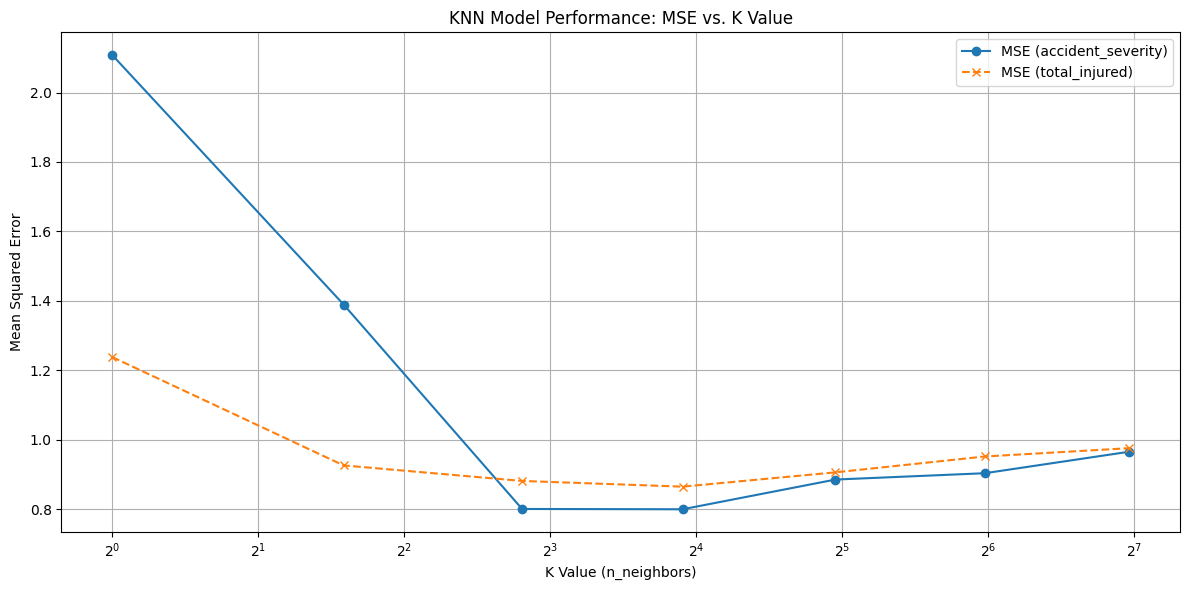

✓ Plot of MSE for accident_severity and total_injured against K values generated.


In [ ]:
# Convert performance_results dictionary to a DataFrame for easier plotting
plot_df = pd.DataFrame.from_dict(performance_results, orient='index')
plot_df.index.name = 'k_value'
plot_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))

# Plot MSE for accident_severity
plt.plot(plot_df['k_value'], plot_df['mse_accident_severity'], marker='o', label='MSE (accident_severity)', linestyle='-')

# Plot MSE for total_injured
plt.plot(plot_df['k_value'], plot_df['mse_total_injured'], marker='x', label='MSE (total_injured)', linestyle='--')

plt.title('KNN Model Performance: MSE vs. K Value')
plt.xlabel('K Value (n_neighbors)')
plt.ylabel('Mean Squared Error')
plt.xticks(plot_df['k_value']) # Ensure all k values are shown on x-axis
plt.grid(True)
plt.legend()
plt.xscale('log', base=2) # Use a log scale for k values as they are powers of 2
plt.tight_layout()
plt.show()

print("✓ Plot of MSE for accident_severity and total_injured against K values generated.")

### 4.2 Training CLASSIFIER using KNN
Predict severe accidents (ie severity >3 OR 3 or more people injured)

In [ ]:
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")
print(f"Shape of the dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded successfully.
Shape of the dataset: 219 rows, 54 columns


In [ ]:
columns_to_keep = [
    #'id', 'date_published',
    'accident_datetime','accident_severity', 'total_injured',
    #'city', 'street',
    'accident_time_category',
    #'driver_under_18', 'driver_18_to_24', 'driver_25_to_49','driver_50_to_64', 'driver_65_plus', 'driver_age_unknown',
    'num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49',
    'num_drivers_50_to_64', 'num_drivers_65_plus', 'num_drivers_age_unknown',
    #'driver_male', 'driver_female', 'driver_gender_unknown',
    'num_drivers_male', 'num_drivers_female', 'num_drivers_gender_unknown', 'num_drivers_total',
    #'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike',
    #'vehicle_car', 'vehicle_van', 'vehicle_bus',
    'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle',
    'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus',
    'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', #'is_school_day_mt',
    'street_type', 'region', 'temperature_max', #'temperature_min', 'temperature_mean',
    #'precipitation_sum', 'windspeed_max',
    'is_raining', 'traffic_level'
   ]

df = df[columns_to_keep]

print(f"✓ Dataset filtered to {len(columns_to_keep)} columns")
print(f"New shape: {df.shape[0]} rows, {df.shape[1]} columns")

✓ Dataset filtered to 29 columns
New shape: 219 rows, 29 columns


In [ ]:
df['accident_datetime'] = pd.to_datetime(df['accident_datetime'])
df = df[df['accident_datetime'] >= '2024-11-01']

print(f"✓ Data filtered to include accidents from November 2024 onwards.")
print(f"New shape: {df.shape[0]} rows, {df.shape[1]} columns")

✓ Data filtered to include accidents from November 2024 onwards.
New shape: 209 rows, 29 columns


In [ ]:
# Extract features from 'accident_datetime'
df['accident_month'] = df['accident_datetime'].dt.month # return month number

# Perform one-hot encoding using pandas get_dummies
# This will create new columns for each category and drop the original columns
df = pd.get_dummies(df, columns=['accident_month'], prefix='accident_month')

# Drop the original 'accident_datetime' column as its derived features have been encoded
df = df.drop(columns=['accident_datetime'])

print("✓ One-hot encoding applied to derived features from 'accident_datetime'")
print(f"New shape of DataFrame after encoding: {df.shape[0]} rows, {df.shape[1]} columns")

✓ One-hot encoding applied to derived features from 'accident_datetime'
New shape of DataFrame after encoding: 209 rows, 39 columns


In [ ]:
# Define the ordinal mapping for accident_severity
# Assuming a logical order from least severe to most severe
severity_order = {
    'not injured': 0,
    'slight': 1,
    'grievious': 2,
    'serious': 3,
    'fatal': 4
}

# Apply the ordinal mapping to the 'accident_severity' column
df['accident_severity'] = df['accident_severity'].map(severity_order)

print("✓ 'accident_severity' column ordinally encoded and original column replaced.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded column:")
print(df['accident_severity'].head())

✓ 'accident_severity' column ordinally encoded and original column replaced.
New shape of DataFrame: 209 rows, 29 columns
First 5 rows of the new encoded column:
10    0
11    2
12    4
13    3
14    3
Name: accident_severity, dtype: int64


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the 'accident_time_category' column
accident_time_category_encoded = encoder.fit_transform(df[['accident_time_category']])

# Create a DataFrame from the encoded data
accident_time_category_df = pd.DataFrame(accident_time_category_encoded, columns=encoder.get_feature_names_out(['accident_time_category']))

# Reset index of df before concatenating to ensure proper alignment
df_reset = df.reset_index(drop=True)

# Concatenate the new DataFrame with the original df
df_combined = pd.concat([df_reset, accident_time_category_df], axis=1)

# Drop the original 'accident_time_category' column
df = df_combined.drop(columns=['accident_time_category'])

print("✓ 'accident_time_category' column one-hot encoded using scikit-learn.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded columns:")
print(df[accident_time_category_df.columns].head())

✓ 'accident_time_category' column one-hot encoded using scikit-learn.
New shape of DataFrame: 209 rows, 44 columns
First 5 rows of the new encoded columns:
   accident_time_category_afternoon  accident_time_category_early_morning  \
0                               1.0                                   0.0   
1                               0.0                                   0.0   
2                               1.0                                   0.0   
3                               1.0                                   0.0   
4                               0.0                                   0.0   

   accident_time_category_evening  accident_time_category_late_evening  \
0                             0.0                                  0.0   
1                             0.0                                  0.0   
2                             0.0                                  0.0   
3                             0.0                                  0.0   
4          

In [ ]:
# Define columns to be one-hot encoded
columns_to_onehot_encode = ['street_type', 'region']

# Perform one-hot encoding using pandas get_dummies
df = pd.get_dummies(df, columns=columns_to_onehot_encode, prefix=columns_to_onehot_encode)

print("✓ One-hot encoding applied to 'street_type' and 'region' columns.")
print(f"New shape of DataFrame after encoding: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded 'street_type' columns:")
print(df[[col for col in df.columns if 'street_type_' in col]].head())
print("First 5 rows of the new encoded 'region' columns:")
print(df[[col for col in df.columns if 'region_' in col]].head())

✓ One-hot encoding applied to 'street_type' and 'region' columns.
New shape of DataFrame after encoding: 209 rows, 53 columns
First 5 rows of the new encoded 'street_type' columns:
   street_type_other  street_type_primary  street_type_residential  \
0              False                False                    False   
1              False                False                     True   
2              False                False                    False   
3              False                False                    False   
4              False                 True                    False   

   street_type_secondary  street_type_tertiary  street_type_trunk  
0                  False                 False               True  
1                  False                 False              False  
2                  False                 False               True  
3                  False                 False               True  
4                  False                 False            

In [ ]:
# Define the ordinal mapping for traffic_level
traffic_level_order = {
    'LOW': 0,
    'MODERATE': 1,
    'HEAVY': 2
}

# Apply the ordinal mapping to the 'traffic_level' column
df['traffic_level_encoded'] = df['traffic_level'].map(traffic_level_order)

# Drop the original 'traffic_level' column
df = df.drop(columns=['traffic_level'])

print("✓ 'traffic_level' column ordinally encoded and original column replaced.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new 'traffic_level_encoded' column:")
print(df['traffic_level_encoded'].head())

✓ 'traffic_level' column ordinally encoded and original column replaced.
New shape of DataFrame: 209 rows, 53 columns
First 5 rows of the new 'traffic_level_encoded' column:
0    1
1    0
2    0
3    0
4    0
Name: traffic_level_encoded, dtype: int64


In [ ]:
# Identify boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns

# Convert boolean columns to int (0 or 1)
df[bool_cols] = df[bool_cols].astype(int)

print(f"✓ Converted {len(bool_cols)} boolean columns to integers (0 or 1).")
print("First 5 rows of the updated DataFrame (boolean columns are now 0/1):")

df.head()

✓ Converted 26 boolean columns to integers (0 or 1).
First 5 rows of the updated DataFrame (boolean columns are now 0/1):


,accident_severity,total_injured,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,...,street_type_residential,street_type_secondary,street_type_tertiary,street_type_trunk,region_Central,region_Gozo,region_Northern,region_South Eastern,region_Southern Harbour,traffic_level_encoded
0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,1,0,0,1,0,0,1
1,2,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,4,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,3,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,3,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df['is_severe_accident'] = ((df['accident_severity'] > 3) | (df['total_injured'] > 3)).astype(int)

print("✓ New target column 'is_severe_accident' created successfully.")
print("Distribution of 'is_severe_accident':")
print(df['is_severe_accident'].value_counts())
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")

✓ New target column 'is_severe_accident' created successfully.
Distribution of 'is_severe_accident':
is_severe_accident
0    174
1     35
Name: count, dtype: int64
New shape of DataFrame: 209 rows, 54 columns


**Reasoning**:
The next step is to split the DataFrame into features (X) and the newly created binary target variable (y), `is_severe_accident`, as specified in the main task, so that they can be used for model training.



In [ ]:
y = df['is_severe_accident']
X = df.drop(columns=['accident_severity', 'total_injured', 'is_severe_accident'])

print("✓ DataFrame successfully split into features (X) and target (y).")
print(f"Shape of X (features): {X.shape[0]} rows, {X.shape[1]} columns")
print(f"Shape of y (target): {y.shape[0]} rows")
print("First 5 rows of X:")
print(X.head())
print("First 5 rows of y:")
print(y.head())

✓ DataFrame successfully split into features (X) and target (y).
Shape of X (features): 209 rows, 51 columns
Shape of y (target): 209 rows
First 5 rows of X:
   num_drivers_under_18  num_drivers_18_to_24  num_drivers_25_to_49  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   num_drivers_50_to_64  num_drivers_65_plus  num_drivers_age_unknown  \
0                     0                    1                        1   
1                     0                    0                        0   
2                     1                    0                        0   
3                     1                    0                        0   
4                     1                    0      

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% temporary (for test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the 30% temporary data into 20% test and 10% validation
# (20% of original is 2/3 of 30%, 10% of original is 1/3 of 30%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333333, random_state=42, stratify=y_temp)

print("✓ Data successfully split into training, testing, and validation sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

✓ Data successfully split into training, testing, and validation sets.
Shape of X_train: (146, 51)
Shape of y_train: (146,)
Shape of X_test: (42, 51)
Shape of y_test: (42,)
Shape of X_val: (21, 51)
Shape of y_val: (21,)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the training features (fit and transform)
X_train_scaled = scaler.fit_transform(X_train)

# Apply StandardScaler to the test and validation features (transform only)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print("✓ Features normalized using StandardScaler.")
print("First 5 rows of X_train_scaled (normalized):")
print(X_train_scaled[:5])


✓ Features normalized using StandardScaler.
First 5 rows of X_train_scaled (normalized):
[[-0.20701967  1.66518936 -0.9069699  -0.55923549 -0.42223595 -0.43432333
  -0.11622583 -0.57476565 -0.51455428 -1.09260349 -0.11785113 -0.20701967
  -0.18831089 -0.87368924  0.2207593  -0.38882222 -0.24077171 -0.64612362
  -0.18831089  1.01379376  0.75144834 -0.71074232 -0.2563073  -0.35082321
  -0.24077171 -0.2563073  -0.28544961 -0.32566947  2.75467517 -0.47633051
  -0.32566947 -0.2244097  -0.32566947 -0.66749124  2.85043856 -0.32566947
  -0.2244097  -0.56152944 -0.49785866 -0.20701967 -0.39840954  1.92605229
  -0.75491223 -0.16783627 -0.52981294  1.57359158 -0.2244097  -0.60372674
  -0.46547467 -0.52981294 -0.43308176]
 [-0.20701967 -0.48629424 -0.9069699  -0.55923549 -0.42223595  1.48722838
  -1.53030672 -0.57476565  1.31776096 -1.09260349 -0.11785113 -0.20701967
  -0.18831089 -0.87368924 -1.31404343 -0.38882222  4.15331193  1.54769145
  -0.18831089  1.01379376  1.12722613 -0.71074232 -0.25630

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define the list of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# Store results
validation_results = {}

print("Training and evaluating KNeighborsClassifier for different k values:")

for k in k_values:
    # Initialize KNeighborsClassifier with current k
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Train the model
    knn_classifier.fit(X_train_scaled, y_train)

    # Make predictions on the validation set
    y_pred_val = knn_classifier.predict(X_val_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred_val)

    validation_results[k] = accuracy

    print(f"\n--- K = {k} ---")
    print(f"  Accuracy on validation set: {accuracy:.4f}")

# Find the best k based on validation accuracy
best_k = max(validation_results, key=validation_results.get)
best_accuracy = validation_results[best_k]

print(f"\n✓ KNeighborsClassifier training and evaluation completed for all specified k values.")
print(f"Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")


Training and evaluating KNeighborsClassifier for different k values:

--- K = 1 ---
  Accuracy on validation set: 0.6667

--- K = 3 ---
  Accuracy on validation set: 0.7143

--- K = 5 ---
  Accuracy on validation set: 0.7143

--- K = 7 ---
  Accuracy on validation set: 0.8095

--- K = 9 ---
  Accuracy on validation set: 0.8095

--- K = 11 ---
  Accuracy on validation set: 0.8095

--- K = 13 ---
  Accuracy on validation set: 0.8095

--- K = 15 ---
  Accuracy on validation set: 0.8095

--- K = 17 ---
  Accuracy on validation set: 0.8095

--- K = 19 ---
  Accuracy on validation set: 0.8095

--- K = 21 ---
  Accuracy on validation set: 0.8095

✓ KNeighborsClassifier training and evaluation completed for all specified k values.
Optimal k on validation set: 7 with accuracy: 0.8095


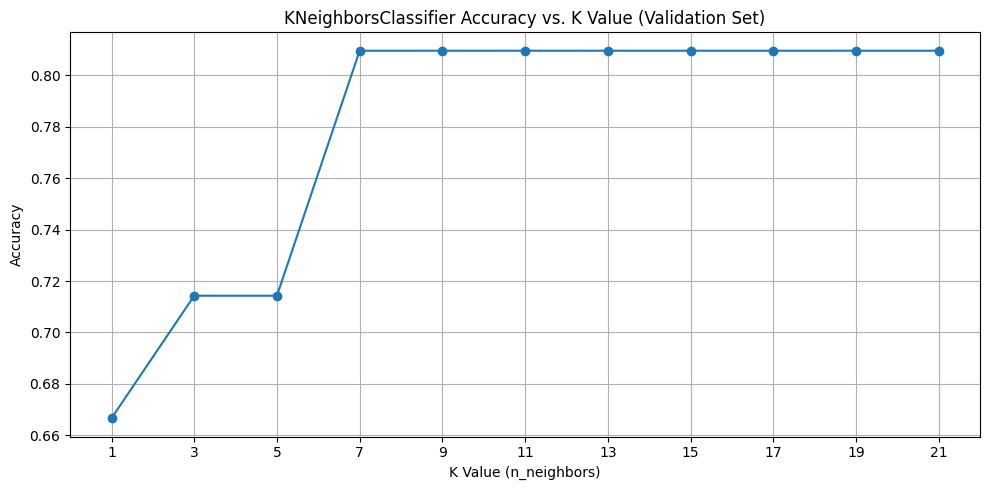

✓ Plot of accuracy against K values generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert validation_results dictionary to a DataFrame for easier plotting
plot_df_acc = pd.DataFrame.from_dict(validation_results, orient='index', columns=['accuracy'])
plot_df_acc.index.name = 'k_value'
plot_df_acc.reset_index(inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(plot_df_acc['k_value'], plot_df_acc['accuracy'], marker='o', linestyle='-')
plt.title('KNeighborsClassifier Accuracy vs. K Value (Validation Set)')
plt.xlabel('K Value (n_neighbors)')
plt.ylabel('Accuracy')
plt.xticks(plot_df_acc['k_value']) # Ensure all k values are shown on x-axis
plt.grid(True)
plt.tight_layout()
plt.show()

print("✓ Plot of accuracy against K values generated.")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Best k value identified from validation set
best_k = 7 # From previous output: Optimal k on validation set: 7

print(f"Evaluating KNeighborsClassifier with best k={best_k} on the test dataset:")

# Initialize KNeighborsClassifier with the best k
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)

# Train the model on the full training data (optional, but good practice)
# In this scenario, we already trained on X_train_scaled in the tuning loop
# and now just evaluate on the test set.
knn_classifier_test.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_test = knn_classifier_test.predict(X_test_scaled)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\n--- Test Set Evaluation (K = {best_k}) ---")
print(f"  Accuracy on test set: {test_accuracy:.4f}")

print("\n✓ KNeighborsClassifier evaluation on test set completed.")

Evaluating KNeighborsClassifier with best k=7 on the test dataset:

--- Test Set Evaluation (K = 7) ---
  Accuracy on test set: 0.7381

✓ KNeighborsClassifier evaluation on test set completed.


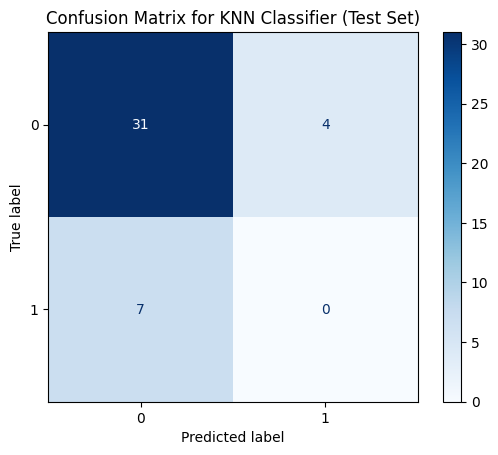

✓ Confusion Matrix displayed.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Test Set)')
plt.show()

print("✓ Confusion Matrix displayed.")

In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test and y_pred_test are already available from the previous step
# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_test, y_pred_test, target_names=target_names)

print("Classification Report for KNN Classifier (Test Set):")
print(report)

print("✓ Precision, Recall, and F1-score calculated and displayed.")

Classification Report for KNN Classifier (Test Set):
                     precision    recall  f1-score   support

Non-Severe Accident       0.82      0.89      0.85        35
    Severe Accident       0.00      0.00      0.00         7

           accuracy                           0.74        42
          macro avg       0.41      0.44      0.42        42
       weighted avg       0.68      0.74      0.71        42

✓ Precision, Recall, and F1-score calculated and displayed.


Insights or Next Steps
*   The difference between validation accuracy ($0.8095$) and test accuracy ($0.7381$) suggests potential overfitting to the validation set or simply variability due to small dataset sizes. Further investigation with more robust cross-validation or larger datasets could provide a more stable estimate of model performance.
*   Given the imbalance in the target variable (35 severe vs. 174 non-severe accidents), evaluating other metrics beyond accuracy, such as precision, recall, F1-score, or ROC AUC, would provide a more comprehensive understanding of the model's performance, especially in correctly identifying severe accidents.


## 5. Evaluation

In [ ]:
# Best k value identified from validation
best_k = 11

print(f"Evaluating KNN model with k={best_k} on the test dataset:")

# Initialize KNeighborsRegressor with the best k and Euclidean distance
k_model_test = KNeighborsRegressor(n_neighbors=best_k, metric='euclidean')

# Train the model using the cleaned training data
k_model_test.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = k_model_test.predict(X_test)

# Calculate Mean Squared Error for each target on the test set
mse_severity_test = mean_squared_error(y_test[:,0], y_pred_test[:, 0])
mse_injured_test = mean_squared_error(y_test[:,1], y_pred_test[:, 1])

print(f"\n--- Test Set Evaluation (K = {best_k}) ---")
print(f"  Mean Squared Error (accident_severity): {mse_severity_test:.4f}")
print(f"  Mean Squared Error (total_injured): {mse_injured_test:.4f}")

print("✓ KNN model evaluation on test set completed.")

Evaluating KNN model with k=11 on the test dataset:

--- Test Set Evaluation (K = 11) ---
  Mean Squared Error (accident_severity): 0.9576
  Mean Squared Error (total_injured): 0.9592
✓ KNN model evaluation on test set completed.


In [ ]:
from sklearn.metrics import r2_score

# Calculate R2 score for 'accident_severity'
r2_severity = r2_score(y_test[:,0], y_pred_test[:, 0])

# Calculate R2 score for 'total_injured'
r2_injured = r2_score(y_test[:,1], y_pred_test[:, 1])

print(f"R2 Score (accident_severity): {r2_severity:.4f}")
print(f"R2 Score (total_injured): {r2_injured:.4f}")
print("✓ R2 scores computed for predictions on the test set.")

R2 Score (accident_severity): 0.0424
R2 Score (total_injured): 0.0408
✓ R2 scores computed for predictions on the test set.


BEST results with K = 15:

R2 Score (accident_severity): 0.0541

R2 Score (total_injured): -0.0788

✓ R2 scores computed for predictions on the test set.

##6. Results

## 7. Interpretation

## 8. Limitations and Ethical considerations